### Research Questions and Goals

# Effectiveness of EPA Environmental Enforcement Actions

####                                                                                                                      -Prashanth Ganesh
####                                                                                                                      -Chenxi Duan
colab link https://drive.google.com/drive/folders/1y2LGa-uN7UnLsTHhx10ZBJavFtZ5iTZv

In recent decades, environmental issues have deeply impacted our life. People are talking about global warming, contamination, air quality, resource conservation, etc. In order to respond citizens’ concerns, since the 1970s, numbers of environmental laws has grown enormously in the U.S., including Clean Air Act, Clean Water Act, Toxic Substances Control Act, Resource Conservation and Recovery Act, and so on. However, there has been relatively few new environmental legislation in the past decades at federal level.



Though there is no influential change of the federal laws, the federal executive government, especially the U.S. Environmental Protection Agency plays an important role to implement federal laws with its policies and regulations to clarify the details of federal laws.

It is the common understanding that EPA could impact and should be effective on environmental issues because of its powerful actions. But the detail of EPA’s actions and the effectiveness of their enforcement still needs more research. 

In order to get the proof of the importance and effectiveness of EPA’s actions, we decided to use publicly available data on the EPA’s website to answer the following questions:
	
	- Are EPA’s actions helpful to address environmental problems?
	- How effective are these actions?
	- Do short-term effectiveness and long-term show the same pattern?
	- What factors influence the effectiveness of the EPA’s action?

The process of exploring and analyzing the data can help answer the above questions, but can also reveal underestimated factors which impact the improvement of the environment. As a course project, it helps group members and viewers to find the facts of EPA’s work; it could also be a resource for policy advocates, the EPA, and citizens to find potential problems of the current executive actions and take steps towards making things better.

### Analysis objects and Index

In order to analyze these questions, we chose a specific environmental law and an objective index as our core indicators to avoid arbitrary conclusions. 

After some research, we decide to focus on the Clean Air Act (CAA), specifically, the CAA violations as documented by EPA, and the long-term effectiveness of enforcement steps taken by the organization after the incident. Meanwhile, we notice the AQI (Air Quality Index) is a suitable index to show the quality of the environment.

AQI is a numerical representation of air quality- it is calculated for four major air pollutants regulated by the CAA, including ground level ozone, particle pollution, carbon monoxide, and sulfur dioxide. In general, the smaller the value, the better the air quality. It is quantitative, which means it is suitable in ordinary data analysis. The dataset is also open and available to access. We use the AQI as the index to compare the environmental quality of certain areas, where the facilities failed to pass the EPA’s inspection and get the formal enforcement action. 

We use the AQI to compare one and two years before the formal penalty, and one and five years later data to get the information of the short-term and long-term effectiveness of the enforcement action.

### Data

Data is always the foundation of the whole process and as such, the accuracy and reliability of the data is a priority in our project. In general, data which is documented by government agencies and open for public access possesses a high level of reliability, so we choose the datasets directly from the EPA’s website.


We use Enforcement and Compliance History Online [ECHO], and Air Quality System [AQS] datasets to get the data we will process. 


 ##### Enforcement and Compliance History Online [ECHO]
 https://echo.epa.gov/tools/data-downloads#downloads 


It provides “a download for more than 1.5 million regulated facilities in one zip file. Over 130 data fields are available for each facility, including the frequency of inspections, violations, actions, and penalties. The file includes facilities regulated as Clean Air Act stationary sources...”


##### Air Quality System[AQS]:
https://aqs.epa.gov/aqsweb/airdata/download_files.html

We use the AQS Annual Summary Data by County from 1980 to 2018.


### Processing Datasets

#### Combining Datasets

The first step of our data preparation is combining these datasets. There are two million rows in ECHO, the dataset has several elements including the basic information of facilities registry ID, country, state, Date of the most recent formal enforcement action, etc. The AQS dataset also shows these columns and these overlapping information make it possible to build our dataset.

The following blocks combine 2 data sources to glean insight into the effectiveness of the EPA's regulatory actions on polluting facilities. The ECHO dataset contains the most recent Clean Air Act enforcement action for each facility. This is contained in ECHO_EXPORTER.csv. First, we build a dictionary that maps (registryId, name, city, state, zip code, county, latitude, longitude) to the date of the most recent formal enforcement action. The next block reads the AQI by County csv. files from 1980-2018 and builds a nested dictionary with the structure {year : {state : {county : {co: w, no2: x, ozone: y, so2: z}}}}. 


In [0]:
import csv
import pandas as pd
import pickle
import os
from abbrev import us_state_abbrev
import folium
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


#scikit-learn
from sklearn.feature_selection import RFE
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeRegressor
from sklearn.feature_selection import SelectFromModel

%matplotlib inline

In [0]:
'''
This reads the ECHO_EXPORTER.csv, which contains the most recent Clean Air Act enforcement action for each facility
and maps (registryid, name, city, state, zipcode, county, latitude, longitude) to the date of the last formal action
'''

data = {}

with open('ECHO_EXPORTER.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    next(csv_reader)
    for row in csv_reader:
        registryid = row[0]
        name = row[1]
        city, state, zipcode, county = row[3], row[4], row[5], row[6]
        latitude, longitude = row[14], row[15]
        last_formal_action = row[62]

        if last_formal_action:
            data[(registryid, name, city, state, zipcode, county, latitude, longitude)] = last_formal_action


In [0]:
'''
This reads the csv files (downloaded into the aqi folder)
from https://aqs.epa.gov/aqsweb/airdata/download_files.html#Annual under 'AQI by County' 
and builds a nested dictionary:

nested dictionary: {year : {state : {county : {co: w, no2: x, ozone: y, so2: z}}}}
'''
aqi_data = {}
for fname in os.listdir('aqi'):
    if not fname.endswith('.csv'):
        continue

    year = fname.split('_')[-1].split('.')[0]

    states = {}
    with open('aqi/%s' % fname) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        top = next(csv_reader)

        for row in csv_reader:
            state = row[0]
            county = row[1]
            median_aqi, co, no, oz, so = int(row[12]), int(row[13]), int(row[14]), int(row[15]), int(row[16])

            if state not in states:
                states[state] = {}

            states[state][county.lower()] = {'median aqi': median_aqi, 'co' : co, 'no' : no, 'oz' : oz, 'so' : so}

        aqi_data[year] = states


Finally, we build 4 pandas dataframes corresponding to AQI, carbon monoxide, nitrous oxide, ozone, sulfur dioxide where the rows of each dataframe correspond to the Registry ID of the problematic facility, the columns are the pollutant levels for the previous 2 years, the current year, and the next 5 years.

In [0]:
'''
Builds 4 pandas dataframes (aqi, carbon monoxide, nitrous oxide, ozone, sulfur dioxide)

The rows of each dataframe correspond to the Registry ID of the problematic facility, the columns are the pollutant 
levels for the current year, next 2 years year, and previous 2 years
'''

to_add_aqi = {}
to_add_co = {}
to_add_no = {}
to_add_oz = {}
to_add_so = {}

for key, date in data.items():

    date = data[key]
    year = date.split('/')[-1]

    try:
        state, county = us_state_abbrev[key[3]], key[5].lower()
    except KeyError: # not US states
        continue

    try:
        previous_year_1 = aqi_data[str(int(year)-2)][state][county]
        previous_year = aqi_data[str(int(year)-1)][state][county]
        current_year = aqi_data[year][state][county]
        next_year = aqi_data[str(int(year)+1)][state][county]
        next_year_1 = aqi_data[str(int(year)+2)][state][county]
        next_year_2 = aqi_data[str(int(year)+2)][state][county]
        next_year_3 = aqi_data[str(int(year)+3)][state][county]
        next_year_4 = aqi_data[str(int(year)+4)][state][county]
    except KeyError: # year not found
        continue

    to_add_aqi[key[0]] = {"previous_year_1": previous_year_1['median aqi'],
                          "previous_year": previous_year['median aqi'], 
                          "current_year": current_year['median aqi'],
                          "next_year": next_year['median aqi'],
                         "next_year_1": next_year_1['median aqi'],
                         "next_year_2": next_year_2['median aqi'],
                          "next_year_3": next_year_3['median aqi'],
                          "next_year_4": next_year_4['median aqi']
                         }
    to_add_co[key[0]] = {"previous_year_1": previous_year_1['co'],
                         "previous_year": previous_year['co'],
                         "current_year": current_year['co'],  
                         "next_year": next_year['co'], 
                         "next_year_1": next_year_1['co'],
                        "next_year_2": next_year_1['co'],
                        "next_year_3": next_year_1['co'],
                        "next_year_4": next_year_1['co']}
    to_add_no[key[0]] = {"previous_year_1": previous_year_1['no'], 
                         "previous_year": previous_year['no'], 
                         "current_year": current_year['no'], 
                         "next_year": next_year['no'], 
                         "next_year_1": next_year_1['no'],
                        "next_year_2": next_year_2['no'],
                        "next_year_3": next_year_3['no'],
                        "next_year_4": next_year_4['no']}
    to_add_oz[key[0]] = {"previous_year_1": previous_year_1['oz'],
                         "previous_year": previous_year['oz'], 
                         "current_year": current_year['oz'], 
                         "next_year": next_year['oz'],
                         "next_year_1": next_year_1['oz'],
                        "next_year_2": next_year_2['oz'],
                        "next_year_3": next_year_3['oz'],
                        "next_year_4": next_year_4['oz']}
    to_add_so[key[0]] = {"previous_year_1": previous_year_1['so'],
                         "previous_year": previous_year['so'], 
                         "current_year": current_year['so'], 
                         "next_year": next_year['so'], 
                         "next_year_1": next_year_1['so'],
                        "next_year_2": next_year_2['so'],
                        "next_year_3": next_year_3['so'],
                        "next_year_4": next_year_4['so']}


df_aqi = pd.DataFrame(to_add_aqi).transpose()
df_co = pd.DataFrame(to_add_co).transpose()
df_no = pd.DataFrame(to_add_no).transpose()
df_oz = pd.DataFrame(to_add_oz).transpose()
df_so = pd.DataFrame(to_add_so).transpose()

In [0]:
print('AQI')
df_aqi.head()

AQI


current_year  next_year  next_year_1  next_year_2  next_year_3  \
110001930402            46         49           44           44           43   
110001662692            40         43           42           42           41   
110008822097            46         41           42           42           43   
110001849778            48         40           37           37           34   
110020463988            39         41           34           34           32   

              next_year_4  previous_year  previous_year_1  
110001930402           48             50               45  
110001662692           46             44               42  
110008822097           45             45               43  
110001849778           36             46               44  
110020463988           32             37               36

In [0]:
print('CO')
df_co.head()

CO


current_year  next_year  next_year_1  next_year_2  next_year_3  \
110001930402             0          0            0            0            0   
110001662692            27         10            5            5            5   
110008822097             0          0            0            0            0   
110001849778             0          0            0            0            0   
110020463988             0          0            0            0            0   

              next_year_4  previous_year  previous_year_1  
110001930402            0              0                0  
110001662692            5             23               33  
110008822097            0              0               23  
110001849778            0              1                0  
110020463988            0              0                0

In [0]:
print('NO2')
df_no.head()

NO2


current_year  next_year  next_year_1  next_year_2  next_year_3  \
110001930402             0          0            0            0            0   
110001662692           109        131          169          169          187   
110008822097            15         33           21           21           19   
110001849778             0          0            0            0            0   
110020463988             0          0            0            0            0   

              next_year_4  previous_year  previous_year_1  
110001930402            0              0                0  
110001662692          122            108              106  
110008822097           12             24               40  
110001849778            0              0                0  
110020463988            0              0                0

In [0]:
print('Ozone')
df_oz.head()

Ozone


current_year  next_year  next_year_1  next_year_2  next_year_3  \
110001930402           166        171          168          168          171   
110001662692           145        128          108          108          116   
110008822097           155        185          162          162          145   
110001849778             0          0            0            0            0   
110020463988           199        194          237          237          325   

              next_year_4  previous_year  previous_year_1  
110001930402          185            169              158  
110001662692           51            127               81  
110008822097          121            105              139  
110001849778            0              0                0  
110020463988          327            188              171

In [0]:
print('SO2')
df_so.head()

SO2


current_year  next_year  next_year_1  next_year_2  next_year_3  \
110001930402             0          0            0            0            0   
110001662692            79         88           79           79           53   
110008822097             1          0            1            1            2   
110001849778             6         20           13           13            8   
110020463988             0          0            0            0            0   

              next_year_4  previous_year  previous_year_1  
110001930402            0              0                0  
110001662692           41             99              136  
110008822097            0              2                3  
110001849778            0             20               34  
110020463988            0              0                0

#### Select Colunmns

The ECHO dataset has more than 130 columns including the general information of the facility, information about the Clean Air Act, Clean Water Act, Resource Conservation and Recovery Act, etc. Since our project focuses on the Clean Air Act, we did some manual feature selection first to eliminate irrelevant features, such as the collection method, latitude, longitude, CWA metrics, etc. This process helps focus the analysis around our project and ensures that the 23 columns are reasonable features. The number of the features make sure the factors we will find are not narrow, but also help us to get details of the impact of each feature.

The remianing colunmns are:

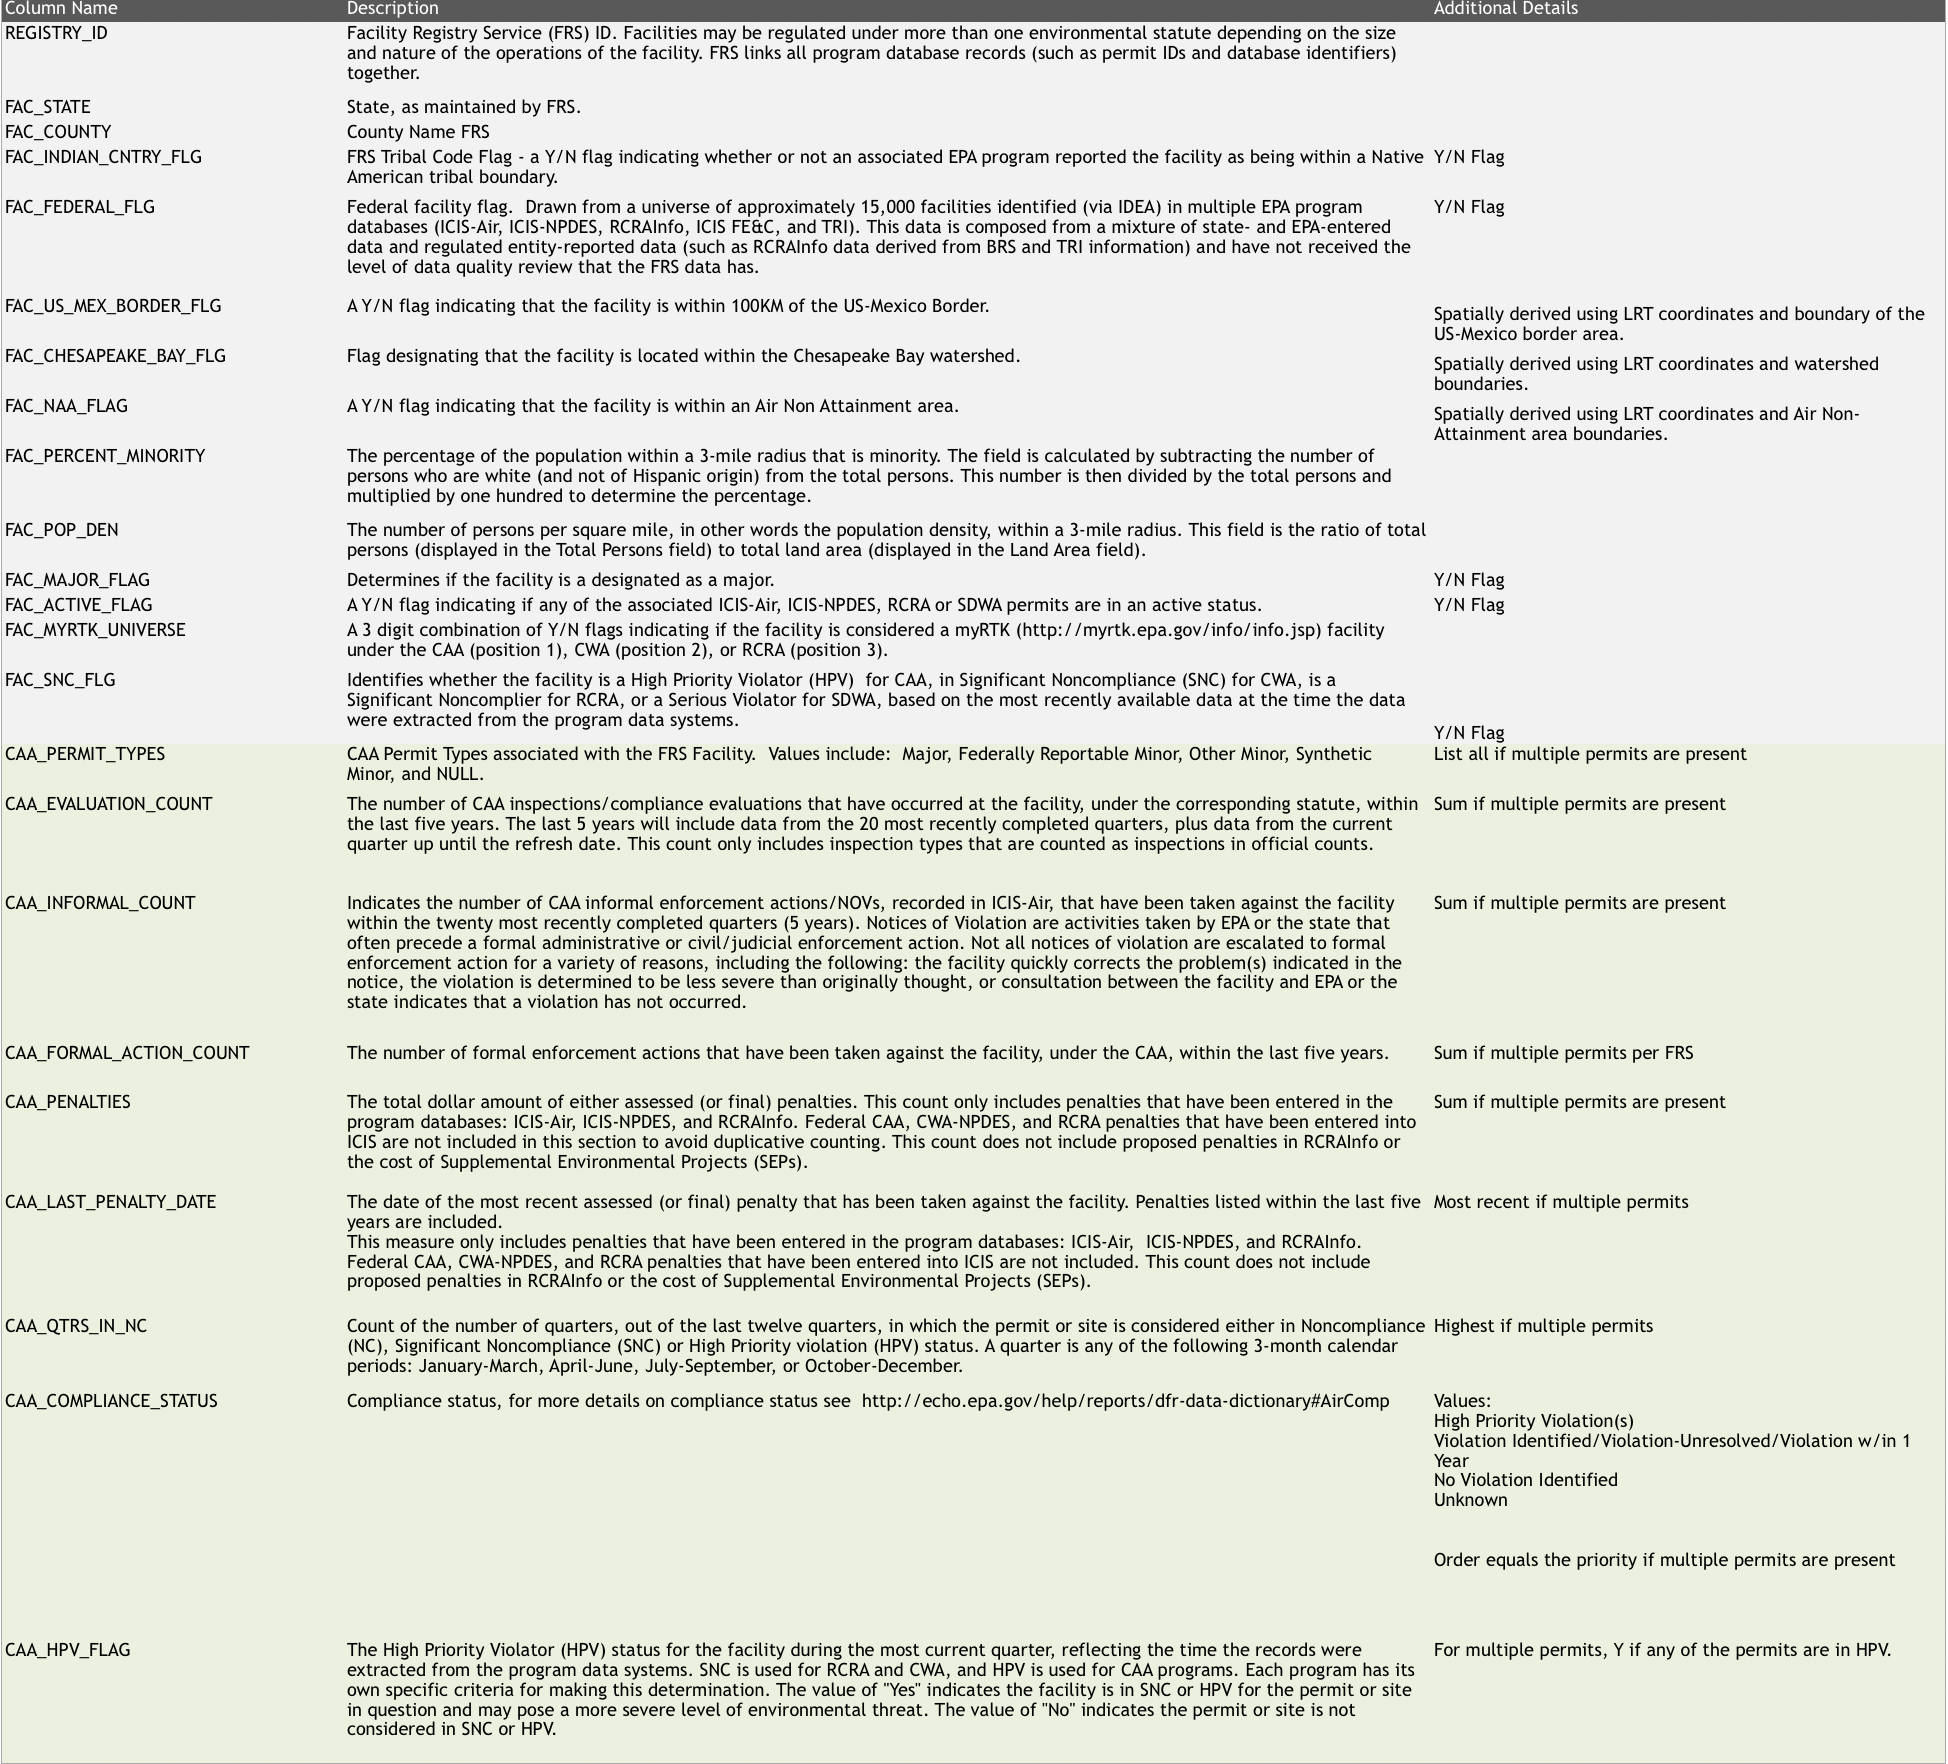

In [0]:
from IPython.display import Image
Image("Feature.png")


In [0]:
'''
make a dictionary mapping the registryid of the facility to the relevant features of interest
'''

features = {}
with open('ECHO_EXPORTER.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    next(csv_reader)
    for row in csv_reader:
        registryid = row[0]
        last_formal_action = row[62]
        if last_formal_action:
            features[registryid] = { 'FAC_STATE': row[4], 'FAC_COUNTY': row[6], 'FAC_INDIAN_CNTRY_FLG': row[9],
                                    'FAC_FEDERAL_FLG': row[10], 'FAC_US_MEX_BORDER_FLG': row[11],'FAC_CHESAPEAKE_BAY_FLG': row[12], 
                                    'FAC_NAA_FLAG': row[13], 'FAC_PERCENT_MINORITY': row[27], 'FAC_POP_DEN': row[28], 
                                    'FAC_MAJOR_FLAG': row[29], 'FAC_ACTIVE_FLAG': row[30], 'FAC_MYRTK_UNIVERSE': row[31], 
                                    'FAC_SNC_FLG': row[46], 'CAA_PERMIT_TYPES': row[55], 'CAA_EVALUATION_COUNT': row[58],
                                    'CAA_INFORMAL_COUNT': row[60], 'CAA_FORMAL_ACTION_COUNT': row[61], 'CAA_PENALTIES': row[63], 
                                    'CAA_LAST_PENALTY_DATE': row[64],'CAA_QTRS_IN_NC': row[66],'CAA_COMPLIANCE_STATUS': row[67],
                                    'CAA_HPV_FLAG': row[68]
                                    }
        

#### Convert Y/N and categories to numerical values

Some selected columns are not numerical. For example, FAC_INDIAN_CNTRY_FLG, which indicates whether or not an associated EPA program reported the facility as being within a Native American tribal boundary, are shown as ‘Y/N’.  In order to make these columns calculable, we cover them to numeric values.


In [0]:
df_features = pd.DataFrame(features).transpose()
df_features.head()

CAA_COMPLIANCE_STATUS CAA_EVALUATION_COUNT  \
110001858525  No Violation Identified                    1   
110001930402  No Violation Identified                    1   
110000584797    Violation w/in 1 Year                    3   
110001662692  No Violation Identified                        
110008324492  No Violation Identified                    1   

             CAA_FORMAL_ACTION_COUNT CAA_HPV_FLAG CAA_INFORMAL_COUNT  \
110001858525                                    N                      
110001930402                                    N                      
110000584797                       3            N                  3   
110001662692                                    N                      
110008324492                       1            N                  1   

             CAA_LAST_PENALTY_DATE CAA_PENALTIES CAA_PERMIT_TYPES  \
110001858525            07/28/1988                Minor Emissions   
110001930402            10/12/2006                                  
110000584797            11/02/2018          6720  Major Emissions   
110001662692            02/10/1995                Minor Emissions   
110008324492            06/29/2015          2138                    

             CAA_QTRS_IN_NC FAC_ACTIVE_FLAG  ... FAC_FEDERAL_FLG  \
110001858525              0               Y  ...                   
110001930402              0               Y  ...                   
110000584797              3               Y  ...                   
110001662692              0               Y  ...                   
110008324492              0                  ...                   

             FAC_INDIAN_CNTRY_FLG FAC_MAJOR_FLAG FAC_MYRTK_UNIVERSE  \
110001858525                    N                               NNN   
110001930402                    N                               NNN   
110000584797                    N              Y                NNY   
110001662692                    N                               NNN   
110008324492                    N                               NNN   

             FAC_NAA_FLAG FAC_PERCENT_MINORITY FAC_POP_DEN FAC_SNC_FLG  \
110001858525                             8.459        40.2           N   
110001930402            Y               20.872      329.61           N   
110000584797            Y               51.644    12066.19           N   
110001662692            Y               38.989     4930.42           N   
110008324492                            31.974     2534.94           N   

             FAC_STATE FAC_US_MEX_BORDER_FLG  
110001858525        TN                        
110001930402        WV                        
110000584797        PA                        
110001662692        RI                        
110008324492        FL                        

[5 rows x 22 columns]

In [0]:
'''
Converting the values in df_features to numerical values, allowing them to be used in our models.
'''
def empty2zero(x, r):
    if not x:
        return r
    return x

# if missing value, replace with 0
df_features['CAA_EVALUATION_COUNT'] = df_features['CAA_EVALUATION_COUNT'].apply(lambda x: empty2zero(x, 0))
df_features['CAA_FORMAL_ACTION_COUNT'] = df_features['CAA_FORMAL_ACTION_COUNT'].apply(lambda x: empty2zero(x, 0))
df_features['CAA_PENALTIES'] = df_features['CAA_PENALTIES'].apply(lambda x: empty2zero(x, 0))
df_features['CAA_INFORMAL_COUNT'] = df_features['CAA_INFORMAL_COUNT'].apply(lambda x: empty2zero(x, 0))
df_features['FAC_PERCENT_MINORITY'] = df_features['FAC_PERCENT_MINORITY'].apply(lambda x: empty2zero(x, 0))
df_features['FAC_POP_DEN'] = df_features['FAC_POP_DEN'].apply(lambda x: empty2zero(x, 0))


# convert CAA_LAST_PENALTY_DATE to years from 2017
def subtract_dates(d):
    if d == -1:
        return d
    return 2017 - int(d.split('/')[-1])
df_features['CAA_LAST_PENALTY_DATE'] = df_features['CAA_LAST_PENALTY_DATE'].apply(lambda x: empty2zero(x, -1)).apply(subtract_dates)

# for columns that contain strings, map these to unique numerical values
unique_compliance = set(df_features['CAA_COMPLIANCE_STATUS'])
compliance_dict = {x: i for (x, i) in zip(unique_compliance, range(len(unique_compliance)))}
df_features['CAA_COMPLIANCE_STATUS'] = df_features['CAA_COMPLIANCE_STATUS'].apply(lambda x: compliance_dict[x])

unique_state = set(df_features['FAC_STATE'])
state_dict = {x: i for (x, i) in zip(unique_state, range(len(unique_state)))}
df_features['FAC_STATE'] = df_features['FAC_STATE'].apply(lambda x: state_dict[x])

unique_county = set(df_features['FAC_COUNTY'])
county_dict = {x: i for (x, i) in zip(unique_county, range(len(unique_county)))}
df_features['FAC_COUNTY'] = df_features['FAC_COUNTY'].apply(lambda x: county_dict[x])

unique_permit = set(df_features['CAA_PERMIT_TYPES'])
permit_dict = {x: i for (x, i) in zip(unique_permit, range(len(unique_permit)))}
df_features['CAA_PERMIT_TYPES'] = df_features['CAA_PERMIT_TYPES'].apply(lambda x: permit_dict[x])

unique_myrtk = set(df_features['FAC_MYRTK_UNIVERSE'])
myrtk_dict = {x: i for (x, i) in zip(unique_myrtk, range(len(unique_myrtk)))}
df_features['FAC_MYRTK_UNIVERSE'] = df_features['FAC_MYRTK_UNIVERSE'].apply(lambda x: myrtk_dict[x])

# for columns that correspond to flags, convert these to numerical values
flag_dict = {'N': 0, 'Y': 1, '': 2} 
df_features['CAA_HPV_FLAG'] = df_features['CAA_HPV_FLAG'].apply(lambda x: flag_dict[x])
df_features['FAC_INDIAN_CNTRY_FLG'] = df_features['FAC_INDIAN_CNTRY_FLG'].apply(lambda x: flag_dict[x])
df_features['FAC_FEDERAL_FLG'] = df_features['FAC_FEDERAL_FLG'].apply(lambda x: flag_dict[x])
df_features['FAC_US_MEX_BORDER_FLG'] = df_features['FAC_US_MEX_BORDER_FLG'].apply(lambda x: flag_dict[x])
df_features['FAC_CHESAPEAKE_BAY_FLG'] = df_features['FAC_CHESAPEAKE_BAY_FLG'].apply(lambda x: flag_dict[x])
df_features['FAC_NAA_FLAG'] = df_features['FAC_NAA_FLAG'].apply(lambda x: flag_dict[x])
df_features['FAC_ACTIVE_FLAG'] = df_features['FAC_ACTIVE_FLAG'].apply(lambda x: flag_dict[x])
df_features['FAC_MAJOR_FLAG'] = df_features['FAC_MAJOR_FLAG'].apply(lambda x: flag_dict[x])
df_features['FAC_SNC_FLG'] = df_features['FAC_SNC_FLG'].apply(lambda x: flag_dict[x])


In [0]:
df_features.head()

CAA_COMPLIANCE_STATUS CAA_EVALUATION_COUNT  \
110001858525                      7                    1   
110001930402                      7                    1   
110000584797                      1                    3   
110001662692                      7                    0   
110008324492                      7                    1   

             CAA_FORMAL_ACTION_COUNT  CAA_HPV_FLAG CAA_INFORMAL_COUNT  \
110001858525                       0             0                  0   
110001930402                       0             0                  0   
110000584797                       3             0                  3   
110001662692                       0             0                  0   
110008324492                       1             0                  1   

              CAA_LAST_PENALTY_DATE CAA_PENALTIES  CAA_PERMIT_TYPES  \
110001858525                     29             0                14   
110001930402                     11             0                 0   
110000584797                     -1          6720                 3   
110001662692                     22             0                14   
110008324492                      2          2138                 0   

             CAA_QTRS_IN_NC  FAC_ACTIVE_FLAG  ...  FAC_FEDERAL_FLG  \
110001858525              0                1  ...                2   
110001930402              0                1  ...                2   
110000584797              3                1  ...                2   
110001662692              0                1  ...                2   
110008324492              0                2  ...                2   

              FAC_INDIAN_CNTRY_FLG  FAC_MAJOR_FLAG  FAC_MYRTK_UNIVERSE  \
110001858525                     0               2                   1   
110001930402                     0               2                   1   
110000584797                     0               1                   5   
110001662692                     0               2                   1   
110008324492                     0               2                   1   

              FAC_NAA_FLAG  FAC_PERCENT_MINORITY  FAC_POP_DEN FAC_SNC_FLG  \
110001858525             2                 8.459         40.2           0   
110001930402             1                20.872       329.61           0   
110000584797             1                51.644     12066.19           0   
110001662692             1                38.989      4930.42           0   
110008324492             2                31.974      2534.94           0   

             FAC_STATE  FAC_US_MEX_BORDER_FLG  
110001858525        25                      2  
110001930402         6                      2  
110000584797        17                      2  
110001662692        29                      2  
110008324492         7                      2  

[5 rows x 22 columns]

### Data Analysis and Visualization 

#### Values of the indexes

First, plotting the change of AQI and other air pollutants is the first step to visualize the environmental quality and the effectiveness of EPA’s action. ‘0’ means the year which EPA formally imposed penalties, ‘1’ is the year after, ‘-1’ is the year before, etc. 
In order to analyze short-term and long-term effectiveness, we choose two years before the action to the five years after the action.


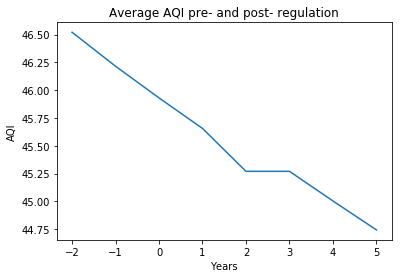

In [0]:
'''
Plot of the average AQI for the previous 2 years and next 5 years of regulatory action
'''

current, nex, nex1, nex2, nex3, nex4, previous, previous_1 = df_aqi.mean()
plt.plot([-2, -1, 0, 1, 2, 3, 4, 5], np.array([previous_1, previous, current, nex, nex1, nex2, nex3, nex4]))


plt.xlabel('Years')
plt.ylabel('AQI')
plt.title('Average AQI pre- and post- regulation')
plt.show()

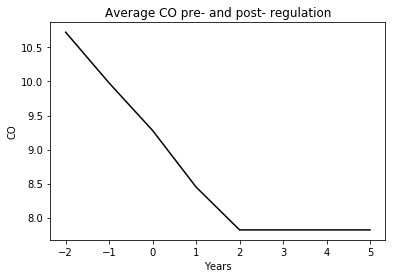

In [0]:
current, nex, nex1, nex2, nex3, nex4, previous, previous_1 = df_co.mean()
plt.plot([-2, -1, 0, 1, 2, 3, 4, 5], np.array([previous_1, previous, current, nex, nex1, nex2, nex3, nex4]), color='black')

plt.xlabel('Years')
plt.ylabel('CO')
plt.title('Average CO pre- and post- regulation')
plt.show()

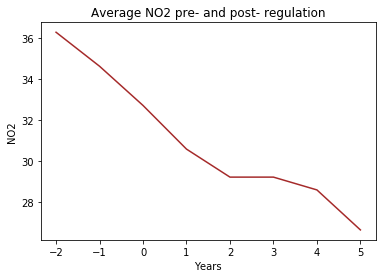

In [0]:
current, nex, nex1, nex2, nex3, nex4, previous, previous_1 = df_no.mean()
plt.plot([-2, -1, 0, 1, 2, 3, 4, 5], np.array([previous_1, previous, current, nex, nex1, nex2, nex3, nex4]), color='brown')

plt.xlabel('Years')
plt.ylabel('NO2')
plt.title('Average NO2 pre- and post- regulation')
plt.show()

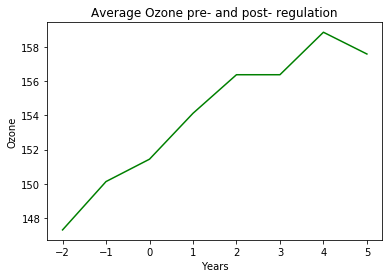

In [0]:
current, nex, nex1, nex2, nex3, nex4, previous, previous_1 = df_oz.mean()
plt.plot([-2, -1, 0, 1, 2, 3, 4, 5], np.array([previous_1, previous, current, nex, nex1, nex2, nex3, nex4]), color='green')

plt.xlabel('Years')
plt.ylabel('Ozone')
plt.title('Average Ozone pre- and post- regulation')
plt.show()

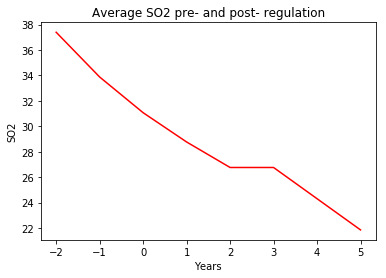

In [0]:
current, nex, nex1, nex2, nex3, nex4, previous, previous_1 = df_so.mean()
plt.plot([-2, -1, 0, 1, 2, 3, 4, 5], np.array([previous_1, previous, current, nex, nex1, nex2, nex3, nex4]), color='red')

plt.xlabel('Years')
plt.ylabel('SO2')
plt.title('Average SO2 pre- and post- regulation')
plt.show()

#### Finding

These four plots show the tendency of the change. Overall, the quality of the environment is improving ((specifically, the AQI is decreasing) in the years after EPA’s actions. In addition to the ground-level ozone, the air quality quickly shows positive changes in the next two years, which indicated short-term effectiveness. However, from the long-term perspective, the patterns are not as good as the short-term. For instance, there is almost no change in AQI, sulfur dioxide in the second year after the actions to the third year. It is undeniable that index values are decreased in the following years.

In the analysis of the indexes, what is unexpected was that the ground-level ozone increased year after year. 

Why is the ground ozone content not falling?

Resources from EPA's website shows: https://www.epa.gov/ground-level-ozone-pollution/ground-level-ozone-basicsResources 

    Ozone can be “good” or “bad” for health and the environment depending on where it’s found in the atmosphere. Groud level ozone is created by chemical reactions between oxides of nitrogen (NOx) and volatile organic compounds (VOC). This happens when pollutants emitted by cars, power plants, industrial boilers, refineries, chemical plants, and other sources chemically react in the presence of sunlight.
    
The above information directly indicates that the reason for the increase in ozone needs more information - It isn't comprehensive to analyze this by only considering the data in this dataset. 



#### Geographical patterns

With the information of the facilities, we think the geographical patterns might provide more useful information:

First, we use green dots to show the 'green facilities', which AQI is increased compared to the EPA's action date.

In [0]:
us_map = folium.Map([39.5, -98.35], zoom_start=4)
for (registryid, name, city, state, zipcode, county, latitude, longitude) in random.sample(list(data), 2000):
    if registryid in df_aqi.index and df_aqi.loc[registryid]['current_year'] - df_aqi.loc[registryid]['next_year_4']:
        folium.CircleMarker(location=[float(latitude), float(longitude)], radius=1, weight=0.5, color='green').add_to(us_map)
us_map

Next, lets combine all the facilities showed by red dots with green dots.

In [0]:
us_map = folium.Map([39.5, -98.35], zoom_start=4)
for (registryid, name, city, state, zipcode, county, latitude, longitude) in random.sample(list(data), 2000):
    if registryid in df_aqi.index and df_aqi.loc[registryid]['current_year'] - df_aqi.loc[registryid]['next_year_4']:
        folium.CircleMarker(location=[float(latitude), float(longitude)], radius=1, weight=0.75, color='green').add_to(us_map)
    else:
        folium.CircleMarker(location=[float(latitude), float(longitude)], radius=1, weight=0.75, color='red').add_to(us_map)
us_map

From the above picture, the facilities with improved air quality are concentrated in the eastern and central eastern United States. Not every region's facilities have improved in air quality.

### Modeling and Prediction

#### Data preparation 

In [0]:
'''
The following block is taken from the Exploratory Data Analysis portion, where we construct 5 tables corresponding to
the AQI, CO, NO2, Ozone, and SO2 from the 2 years prior to and the 5 years following the last formal action levied 
upon the facility of interest.

-----------

This reads the ECHO_EXPORTER.csv, which contains the most recent Clean Air Act enforcement action for each facility
and maps (registryid, name, city, state, zipcode, county, latitude, longitude) to the date of the last formal action
'''

data = {}

with open('ECHO_EXPORTER.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    next(csv_reader)
    for row in csv_reader:
        registryid = row[0]
        name = row[1]
        city, state, zipcode, county = row[3], row[4], row[5], row[6]
        latitude, longitude = row[14], row[15]
        last_formal_action = row[62]

        if last_formal_action:
            data[(registryid, name, city, state, zipcode, county, latitude, longitude)] = last_formal_action

            
'''
This reads the csv files (downloaded into the aqi folder)
from https://aqs.epa.gov/aqsweb/airdata/download_files.html#Annual under 'AQI by County' 
and builds a nested dictionary:

nested dictionary: {year : {state : {county : {co: w, no2: x, ozone: y, so2: z}}}}
'''
aqi_data = {}
for fname in os.listdir('aqi'):
    if not fname.endswith('.csv'):
        continue

    year = fname.split('_')[-1].split('.')[0]

    states = {}
    with open('aqi/%s' % fname) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        top = next(csv_reader)

        for row in csv_reader:
            state = row[0]
            county = row[1]
            median_aqi, co, no, oz, so = int(row[12]), int(row[13]), int(row[14]), int(row[15]), int(row[16])

            if state not in states:
                states[state] = {}

            states[state][county.lower()] = {'median aqi': median_aqi, 'co' : co, 'no' : no, 'oz' : oz, 'so' : so}

        aqi_data[year] = states
        
'''
Builds 4 pandas dataframes (aqi, carbon monoxide, nitrous oxide, ozone, sulfur dioxide)

The rows of each dataframe correspond to the Registry ID of the problematic facility, the columns are the pollutant 
levels for the current year, next 2 years year, and previous 2 years
'''

to_add_aqi = {}
to_add_co = {}
to_add_no = {}
to_add_oz = {}
to_add_so = {}

for key, date in data.items():

    date = data[key]
    year = date.split('/')[-1]

    try:
        state, county = us_state_abbrev[key[3]], key[5].lower()
    except KeyError: # not US states
        continue

    try:
        previous_year_1 = aqi_data[str(int(year)-2)][state][county]
        previous_year = aqi_data[str(int(year)-1)][state][county]
        current_year = aqi_data[year][state][county]
        next_year = aqi_data[str(int(year)+1)][state][county]
        next_year_1 = aqi_data[str(int(year)+2)][state][county]
        next_year_2 = aqi_data[str(int(year)+2)][state][county]
        next_year_3 = aqi_data[str(int(year)+3)][state][county]
        next_year_4 = aqi_data[str(int(year)+4)][state][county]
    except KeyError: # year not found
        continue

    to_add_aqi[key[0]] = {"previous_year_1": previous_year_1['median aqi'],
                          "previous_year": previous_year['median aqi'], 
                          "current_year": current_year['median aqi'],
                          "next_year": next_year['median aqi'],
                         "next_year_1": next_year_1['median aqi'],
                         "next_year_2": next_year_2['median aqi'],
                          "next_year_3": next_year_3['median aqi'],
                          "next_year_4": next_year_4['median aqi']
                         }
    to_add_co[key[0]] = {"previous_year_1": previous_year_1['co'],
                         "previous_year": previous_year['co'],
                         "current_year": current_year['co'],  
                         "next_year": next_year['co'], 
                         "next_year_1": next_year_1['co'],
                        "next_year_2": next_year_1['co'],
                        "next_year_3": next_year_1['co'],
                        "next_year_4": next_year_1['co']}
    to_add_no[key[0]] = {"previous_year_1": previous_year_1['no'], 
                         "previous_year": previous_year['no'], 
                         "current_year": current_year['no'], 
                         "next_year": next_year['no'], 
                         "next_year_1": next_year_1['no'],
                        "next_year_2": next_year_2['no'],
                        "next_year_3": next_year_3['no'],
                        "next_year_4": next_year_4['no']}
    to_add_oz[key[0]] = {"previous_year_1": previous_year_1['oz'],
                         "previous_year": previous_year['oz'], 
                         "current_year": current_year['oz'], 
                         "next_year": next_year['oz'],
                         "next_year_1": next_year_1['oz'],
                        "next_year_2": next_year_2['oz'],
                        "next_year_3": next_year_3['oz'],
                        "next_year_4": next_year_4['oz']}
    to_add_so[key[0]] = {"previous_year_1": previous_year_1['so'],
                         "previous_year": previous_year['so'], 
                         "current_year": current_year['so'], 
                         "next_year": next_year['so'], 
                         "next_year_1": next_year_1['so'],
                        "next_year_2": next_year_2['so'],
                        "next_year_3": next_year_3['so'],
                        "next_year_4": next_year_4['so']}


df_aqi = pd.DataFrame(to_add_aqi).transpose()
df_co = pd.DataFrame(to_add_co).transpose()
df_no = pd.DataFrame(to_add_no).transpose()
df_oz = pd.DataFrame(to_add_oz).transpose()
df_so = pd.DataFrame(to_add_so).transpose()

In [0]:
'''
Join the AQI table with the features table along the registryid. If the difference is positive, then the AQI improved 
after the formal action, and if it is negative, then it deteriorated.
'''
df_aqi['difference_aqi'] = df_aqi['previous_year_1'] - df_aqi['next_year_4']
df_features = df_features.join(df_aqi[['difference_aqi']])
df_features = df_features[np.isfinite(df_features['difference_aqi'])]

df_co['difference_co'] = df_co['previous_year_1'] - df_co['next_year_4']
df_features = df_features.join(df_co[['difference_co']])
df_features = df_features[np.isfinite(df_features['difference_co'])]

df_no['difference_no'] = df_no['previous_year_1'] - df_no['next_year_4']
df_features = df_features.join(df_no[['difference_no']])
df_features = df_features[np.isfinite(df_features['difference_no'])]

df_oz['difference_oz'] = df_oz['previous_year_1'] - df_oz['next_year_4']
df_features = df_features.join(df_oz[['difference_oz']])
df_features = df_features[np.isfinite(df_features['difference_oz'])]

df_so['difference_so'] = df_so['previous_year_1'] - df_so['next_year_4']
df_features = df_features.join(df_so[['difference_so']])
df_features = df_features[np.isfinite(df_features['difference_so'])]

In [0]:
df_features = df_features.applymap(float)
df_features.head()

CAA_COMPLIANCE_STATUS  CAA_EVALUATION_COUNT  \
110001930402                    7.0                   1.0   
110001662692                    7.0                   0.0   
110008822097                    7.0                   0.0   
110001849778                    7.0                   0.0   
110020463988                    7.0                   0.0   

              CAA_FORMAL_ACTION_COUNT  CAA_HPV_FLAG  CAA_INFORMAL_COUNT  \
110001930402                      0.0           0.0                 0.0   
110001662692                      0.0           0.0                 0.0   
110008822097                      0.0           0.0                 0.0   
110001849778                      0.0           0.0                 0.0   
110020463988                      0.0           0.0                 0.0   

              CAA_LAST_PENALTY_DATE  CAA_PENALTIES  CAA_PERMIT_TYPES  \
110001930402                   11.0            0.0               0.0   
110001662692                   22.0            0.0              14.0   
110008822097                   12.0            0.0              14.0   
110001849778                   10.0            0.0              14.0   
110020463988                    5.0            0.0              14.0   

              CAA_QTRS_IN_NC  FAC_ACTIVE_FLAG  ...  FAC_PERCENT_MINORITY  \
110001930402             0.0              1.0  ...                20.872   
110001662692             0.0              1.0  ...                38.989   
110008822097             0.0              1.0  ...                 5.956   
110001849778             0.0              1.0  ...                30.263   
110020463988             0.0              1.0  ...                15.987   

              FAC_POP_DEN  FAC_SNC_FLG  FAC_STATE  FAC_US_MEX_BORDER_FLG  \
110001930402       329.61          0.0        6.0                    2.0   
110001662692      4930.42          0.0       29.0                    2.0   
110008822097       294.23          0.0       26.0                    2.0   
110001849778      4608.64          0.0       26.0                    2.0   
110020463988      1523.05          0.0       26.0                    2.0   

              difference_aqi  difference_co  difference_no  difference_oz  \
110001930402            -3.0            0.0            0.0          -27.0   
110001662692            -4.0           28.0          -16.0           30.0   
110008822097            -2.0           23.0           28.0           18.0   
110001849778             8.0            0.0            0.0            0.0   
110020463988             4.0            0.0            0.0         -156.0   

              difference_so  
110001930402            0.0  
110001662692           95.0  
110008822097            3.0  
110001849778           34.0  
110020463988            0.0  

[5 rows x 27 columns]

#####  Modeling1

Without any features selection, let's see what happens to the three commonly used models.

In [0]:
X = df_features.drop(['difference_aqi', 'difference_co', 'difference_no', 'difference_oz', 'difference_so'], axis = 1)
y = df_features['difference_aqi']

np.random.seed(10)
X, X_test, y, y_test = train_test_split(X, y, train_size=0.80, test_size=0.20)
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.75, test_size=0.25)

first_model_reg = LinearRegression()
first_model_lasso = Lasso(alpha=0.1)
first_model_dt = DecisionTreeRegressor()

first_model_r = first_model_reg.fit(X_train, y_train)
first_model_l = first_model_lasso.fit(X_train, y_train)
first_model_dt = first_model_dt.fit(X_train, y_train)

first_pred_r = first_model_r.predict(X_train)
val_pred_r = first_model_r.predict(X_val)

first_pred_l = first_model_l.predict(X_train)
val_pred_l = first_model_l.predict(X_val)

first_pred_dt = first_model_dt.predict(X_train)
val_pred_dt = first_model_dt.predict(X_val)

In [0]:
def rmse(pred, actual):
    return np.sqrt(np.mean((pred - actual) ** 2))

In [0]:
first_train_error_r = rmse(first_pred_r, y_train)
first_val_error_r = rmse(val_pred_r, y_val)

first_train_error_l = rmse(first_pred_l, y_train)
first_val_error_l = rmse(val_pred_l, y_val)

first_train_error_dt = rmse(first_pred_dt, y_train)
first_val_error_dt = rmse(val_pred_dt, y_val)

print("Training RMSE regression:", first_train_error_r)
print("Validation RMSE regression:", first_val_error_r)
print()
print("Training RMSE lasso:", first_train_error_l)
print("Validation RMSE lasso:", first_val_error_l)
print()
print("Training RMSE decision tree:", first_train_error_dt)
print("Validation RMSE decision tree:", first_val_error_dt)

Training RMSE regression: 9.80449006664236
Validation RMSE regression: 9.465422539933344

Training RMSE lasso: 9.820488357698277
Validation RMSE lasso: 9.45773094911011

Training RMSE decision tree: 0.7570097066080002
Validation RMSE decision tree: 10.514468524396419


#### Feature Selections:

##### Correlation matrix and modeling 2

In this section, we use the correlation matrix in order to select which features to use in the predictors.

As the Columns Selection part states, the columns we selected is used for better analysis. The manual selection didn’t narrow down the potential influential features. We think the following feature selection by computer will provide more details of the features and help us to find the accurate guide. It might be helpful to improve our models!

CAA_COMPLIANCE_STATUS  CAA_EVALUATION_COUNT  \
CAA_COMPLIANCE_STATUS                 1.000000             -0.126777   
CAA_EVALUATION_COUNT                 -0.126777              1.000000   
CAA_FORMAL_ACTION_COUNT              -0.037709              0.062981   
CAA_HPV_FLAG                         -0.360544              0.098496   
CAA_INFORMAL_COUNT                   -0.269175              0.207495   
CAA_LAST_PENALTY_DATE                 0.006515              0.006380   
CAA_PENALTIES                        -0.018932              0.015832   
CAA_PERMIT_TYPES                      0.096384             -0.428190   
CAA_QTRS_IN_NC                       -0.478891              0.129485   
FAC_ACTIVE_FLAG                       0.055264             -0.200382   
FAC_CHESAPEAKE_BAY_FLG                0.011161             -0.064733   
FAC_COUNTY                           -0.010026              0.029881   
FAC_FEDERAL_FLG                       0.012774             -0.038903   
FAC_INDIAN_CNTRY_FLG                 -0.013607              0.001063   
FAC_MAJOR_FLAG                        0.097655             -0.473224   
FAC_MYRTK_UNIVERSE                   -0.080126              0.239198   
FAC_NAA_FLAG                          0.001595              0.039085   
FAC_PERCENT_MINORITY                  0.011960              0.002390   
FAC_POP_DEN                           0.040166             -0.134289   
FAC_SNC_FLG                                NaN                   NaN   
FAC_STATE                             0.055091             -0.173240   
FAC_US_MEX_BORDER_FLG                 0.028707             -0.119720   
difference_aqi                       -0.020849              0.040007   

                         CAA_FORMAL_ACTION_COUNT  CAA_HPV_FLAG  \
CAA_COMPLIANCE_STATUS                  -0.037709     -0.360544   
CAA_EVALUATION_COUNT                    0.062981      0.098496   
CAA_FORMAL_ACTION_COUNT                 1.000000      0.077671   
CAA_HPV_FLAG                            0.077671      1.000000   
CAA_INFORMAL_COUNT                      0.110284      0.118512   
CAA_LAST_PENALTY_DATE                  -0.124633     -0.029153   
CAA_PENALTIES                           0.293039      0.053812   
CAA_PERMIT_TYPES                       -0.012010     -0.084204   
CAA_QTRS_IN_NC                          0.081057      0.915498   
FAC_ACTIVE_FLAG                        -0.046666     -0.034169   
FAC_CHESAPEAKE_BAY_FLG                  0.015295      0.016880   
FAC_COUNTY                              0.025745      0.012879   
FAC_FEDERAL_FLG                         0.014993     -0.012191   
FAC_INDIAN_CNTRY_FLG                   -0.003432      0.028919   
FAC_MAJOR_FLAG                         -0.005356     -0.130210   
FAC_MYRTK_UNIVERSE                      0.005597      0.065926   
FAC_NAA_FLAG                           -0.010342     -0.015733   
FAC_PERCENT_MINORITY                   -0.008309      0.040133   
FAC_POP_DEN                            -0.032614     -0.014554   
FAC_SNC_FLG                                  NaN           NaN   
FAC_STATE                              -0.030344     -0.019166   
FAC_US_MEX_BORDER_FLG                  -0.008604     -0.137945   
difference_aqi                          0.013968      0.005332   

                         CAA_INFORMAL_COUNT  CAA_LAST_PENALTY_DATE  \
CAA_COMPLIANCE_STATUS             -0.269175               0.006515   
CAA_EVALUATION_COUNT               0.207495               0.006380   
CAA_FORMAL_ACTION_COUNT            0.110284              -0.124633   
CAA_HPV_FLAG                       0.118512              -0.029153   
CAA_INFORMAL_COUNT                 1.000000              -0.017050   
CAA_LAST_PENALTY_DATE             -0.017050               1.000000   
CAA_PENALTIES                      0.012496              -0.038262   
CAA_PERMIT_TYPES                  -0.142547              -0.061700   
CAA_QTRS_IN_NC                     0.203162              -0.031895   
FAC_ACTIVE_

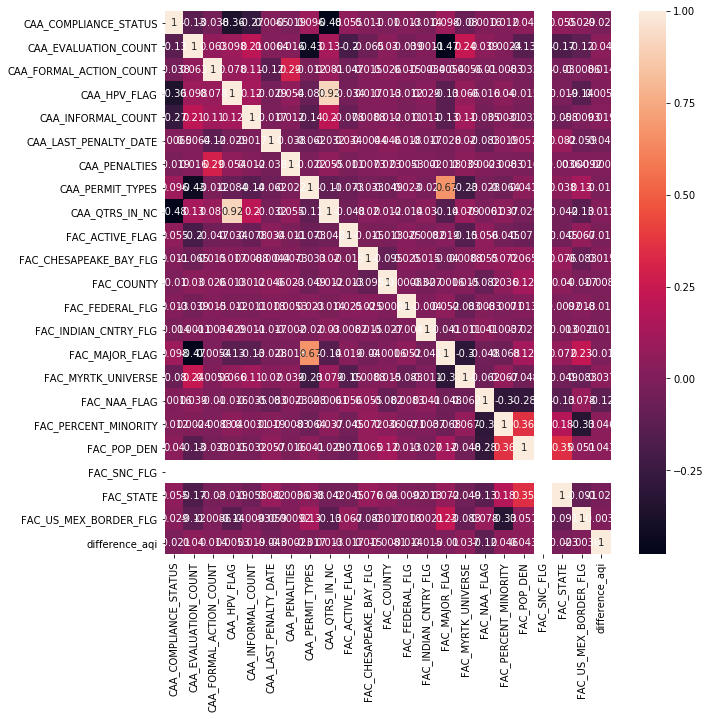

In [0]:
corrmat = df_features.drop(['difference_co', 'difference_no', 'difference_oz', 'difference_so'], axis=1).corr()
plt.figure(figsize=(10,10))
g = sns.heatmap(corrmat, annot=True)
corrmat

Here, we keep those features with a correlation of greater than 0.01 with the AQI change.

In [0]:
aqi_correlations = {}
last_row = corrmat.tail(1)
for column in corrmat.tail(1):
    aqi_correlations[column] = last_row[column]['difference_aqi']
sorted_corr = sorted(aqi_correlations.items(), key=lambda x: x[1])
keep_features = [x[0] for x in sorted_corr if x[1] >= 0.01][:-1]

In [0]:
keep_features

['CAA_QTRS_IN_NC',
 'CAA_FORMAL_ACTION_COUNT',
 'FAC_CHESAPEAKE_BAY_FLG',
 'CAA_INFORMAL_COUNT',
 'FAC_MYRTK_UNIVERSE',
 'CAA_EVALUATION_COUNT',
 'FAC_POP_DEN',
 'FAC_PERCENT_MINORITY']

In [0]:
X_train_my_feats = X_train[keep_features]
X_val_my_feats = X_val[keep_features]

lin_reg = LinearRegression()
lasso_reg = Lasso(alpha=0.1)
dt_reg = DecisionTreeRegressor()

# fit the model
lin_model = lin_reg.fit(X_train_my_feats, y_train)
lasso_model = lasso_reg.fit(X_train_my_feats, y_train)
dt_model = dt_reg.fit(X_train_my_feats, y_train)

lin_train_pred = lin_model.predict(X_train_my_feats)
lin_val_pred = lin_model.predict(X_val_my_feats)

lasso_train_pred = lasso_model.predict(X_train_my_feats)
lasso_val_pred = lasso_model.predict(X_val_my_feats)

dt_train_pred = dt_model.predict(X_train_my_feats)
dt_val_pred = dt_model.predict(X_val_my_feats)

second_train_error_r = rmse(lin_train_pred, y_train)
second_val_error_r = rmse(lin_val_pred, y_val)

second_train_error_l = rmse(lasso_train_pred, y_train)
second_val_error_l = rmse(lasso_val_pred, y_val)

second_train_error_dt = rmse(dt_train_pred, y_train)
second_val_error_dt = rmse(dt_val_pred, y_val)

print("Training RMSE linear:", second_train_error_r)
print("Validation RMSE linear:", second_val_error_r)
print()
print("Training RMSE lasso:", second_train_error_l)
print("Validation RMSE lasso:", second_val_error_l)
print()
print("Training RMSE lasso:", second_train_error_dt)
print("Validation RMSE lasso:", second_val_error_dt)

Training RMSE linear: 9.883135703540475
Validation RMSE linear: 9.520394904535857

Training RMSE lasso: 9.886605038917656
Validation RMSE lasso: 9.521837846966704

Training RMSE lasso: 2.6195099628558824
Validation RMSE lasso: 14.467214861856108


As we saw here, this method did not offer significant improvement over the method using all of the features. The possible reason is these selected features have large impacts on the previous model. The other feature besides the key features are not influential in these models.

##### Recursive feature elimination & modeling 3

In [0]:
# create a base classifier used to evaluate a subset of attributes
linear_model = LinearRegression()
lasso_model = Lasso(alpha=0.1)
dt_model = DecisionTreeRegressor()

# create the RFE model and select 10 attributes
rfe_lm = RFE(linear_model, 10)
rfe_lm.fit(X_train, y_train)

rfe_ls = RFE(lasso_model, 10)
rfe_ls.fit(X_train, y_train)

rfe_dt = RFE(dt_model, 10)
rfe_dt.fit(X_train, y_train)

RFE(estimator=DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best'),
  n_features_to_select=10, step=1, verbose=0)

In [0]:
# using rfe, predict your training set
new_pred_lm = rfe_lm.predict(X_train)
new_pred_ls = rfe_ls.predict(X_train)
new_pred_dt = rfe_dt.predict(X_train)


# now predict your test set
new_val_pred_lm = rfe_lm.predict(X_val)
new_val_pred_ls = rfe_ls.predict(X_val)
new_val_pred_dt = rfe_dt.predict(X_val)

train_error_lm = rmse(new_pred_lm, y_train)
val_error_lm = rmse(new_val_pred_lm, y_val)

train_error_ls = rmse(new_pred_ls, y_train)
val_error_ls = rmse(new_val_pred_ls, y_val)

train_error_dt = rmse(new_pred_dt, y_train)
val_error_dt = rmse(new_val_pred_dt, y_val)

print("Training RMSE linear:", train_error_lm)
print("Validation RMSE linear:", val_error_lm)
print()
print("Training RMSE lasso:", train_error_ls)
print("Validation RMSE lasso:", val_error_ls)
print()
print("Training RMSE decision tree:", train_error_dt)
print("Validation RMSE decision tree:", val_error_dt)

Training RMSE linear: 9.830972464348678
Validation RMSE linear: 9.455674897542837

Training RMSE lasso: 9.820639069638784
Validation RMSE lasso: 9.457319891184227

Training RMSE decision tree: 0.8835960316804544
Validation RMSE decision tree: 10.71062462923324


#### Findings from the modeling process

The features selection process, especially the key features selected by correlation matrix shows the influential factors in the air quality improvement process.
These features are:

In [0]:
#These features are:
#The following main features are in ascending order
keep_features

['CAA_QTRS_IN_NC',
 'CAA_FORMAL_ACTION_COUNT',
 'FAC_CHESAPEAKE_BAY_FLG',
 'CAA_INFORMAL_COUNT',
 'FAC_MYRTK_UNIVERSE',
 'CAA_EVALUATION_COUNT',
 'FAC_POP_DEN',
 'FAC_PERCENT_MINORITY']

It is an important finding that ‘FAC_PERCENT_MINORITY’ ( The percentage of the population within a 3-mile radius that is minority) is present here. The field is calculated by subtracting the number of persons who are white (and not of Hispanic origin) from the total persons. This number is then divided by the total persons and multiplied by one hundred to determine the percentage.) and is the most influential factor in the effectiveness of the enforcement action.


The number of enforcement actions that have been taken against the facility is showed by :'CAA_QTRS_IN_NC' ,'CAA_FORMAL_ACTION_COUNT','CAA_INFORMAL_COUNT', and 'CAA_EVALUATION_COUNT'. 
    
They are the direct features shows the effectiveness of EPA's action.
They are main parts of the influential features, but the question is they are not the most influential features.


## Conclusion

In general, the EPA’s actions are effective. The mean value of AQI is decreasing within the years. The features related to EPA’s actions are also the main part of influential factors.

But this project shows more details and provide future research questions for us. One thing needs to be notified before understanding the influential factors which are selected by correlation matrix is the actual meaning of the influential factors. The factors are highly related to the value of AQI, but this method doesn’t provide any information about whether the impacts are negative or positive.

First, the increase of ground-level ozone. The data analysis part just shows this unexpected finding, but the features selection part provides some reason for it. The top two influential features are the percentage of the population within a 3-mile radius that is minority and the density of population. These features are related to ‘the pollutants emitted by cars, power plants, industrial boilers, refineries, chemical plants, and other sources chemically react in the presence of sunlight.’ We assume the more population, more ground-level ozone. But it still needs future considered research.

Second, the most influential factor is ‘FAC_PERCENT_MINORITY’, the percentage of the population within a 3-mile radius that is minority. Since we don’t know the features are positively or negatively impacting the air quality, we cannot say the minorities are facing disproportionate impact. We want to draw a conclusion, which indicates with the several decades’ effort, people in the U.S., the industry, the executive branch pay more attention to the areas where the minorities live in. 

Third, the geographic pattern of facilities with great performances. Since there are more improvements in eastern and central eastern, EPA could use these information to allocate its resources to protect the environment.

Finally, the project also has several limitations. In addition to the features selection method we use, the index itself also complicated. For example, external factors such as forest fires could influence the air quality dramatically. Using mean values to describe patterns might be influenced by external noise. Using AQI as the only index to analyze the effectiveness of EPA’s actions on environment protection might be less persuasive, but we still believe that this is a great start to understanding the effectiveness of EPA’s actions. It could be very uselful for others who want to find details of the environmental issues. 